In [6]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,AveragePooling2D, Input, ZeroPadding2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from zipfile import ZipFile
import json
import os

In [7]:
#KAGGLE creds
kaggle_creds = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

In [8]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:29<00:00, 119MB/s]
100% 2.04G/2.04G [00:29<00:00, 75.1MB/s]


In [9]:
!ls

kaggle.json  plantvillage-dataset.zip  sample_data


In [10]:
#unzip
with ZipFile('plantvillage-dataset.zip', 'r') as zipObj:
   zipObj.extractall()

In [11]:
print(os.listdir('/content/plantvillage dataset'))

['segmented', 'color', 'grayscale']


In [12]:
print(len(os.listdir('/content/plantvillage dataset/color')))

38


In [13]:
diseases = os.listdir('/content/plantvillage dataset/color')
no_imgs = []
for disease in diseases:
  no_imgs.append(len(os.listdir('/content/plantvillage dataset/color/' + disease)))
for d,i in zip(diseases, no_imgs):
  print(d , i , end = '\n')

Potato___Early_blight 1000
Corn_(maize)___Common_rust_ 1192
Tomato___Target_Spot 1404
Orange___Haunglongbing_(Citrus_greening) 5507
Apple___Cedar_apple_rust 275
Squash___Powdery_mildew 1835
Cherry_(including_sour)___Powdery_mildew 1052
Potato___Late_blight 1000
Tomato___Bacterial_spot 2127
Pepper,_bell___Bacterial_spot 997
Potato___healthy 152
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 513
Cherry_(including_sour)___healthy 854
Grape___Esca_(Black_Measles) 1383
Apple___Black_rot 621
Corn_(maize)___Northern_Leaf_Blight 985
Tomato___Early_blight 1000
Soybean___healthy 5090
Tomato___Tomato_Yellow_Leaf_Curl_Virus 5357
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 1076
Grape___Black_rot 1180
Tomato___Septoria_leaf_spot 1771
Tomato___healthy 1591
Strawberry___Leaf_scorch 1109
Peach___Bacterial_spot 2297
Blueberry___healthy 1502
Grape___healthy 423
Tomato___Tomato_mosaic_virus 373
Apple___healthy 1645
Corn_(maize)___healthy 1162
Tomato___Spider_mites Two-spotted_spider_mite 1676
Apple___A

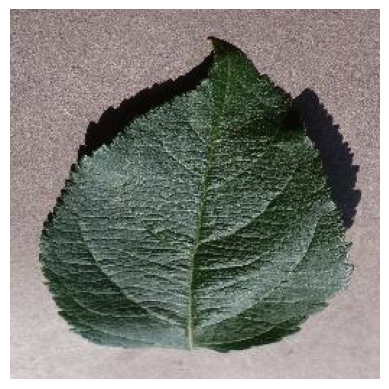

In [14]:
image_path = '/content/plantvillage dataset/color/Apple___healthy/00907d8b-6ae6-4306-bfd7-d54471981a86___RS_HL 5709.JPG'

image = mpimg.imread(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [15]:
image.shape

(256, 256, 3)

In [67]:
#set params
img_size = 128
batch_size = 32

In [68]:
#datagen
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
)

In [69]:
#train data
train_data = datagen.flow_from_directory(
    directory = '/content/plantvillage dataset/color',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)

Found 43456 images belonging to 38 classes.


In [70]:
#test data
test_data = datagen.flow_from_directory(
    directory = '/content/plantvillage dataset/color',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 10849 images belonging to 38 classes.


In [71]:
#identity block
def id_block (x,filter):
  x_skip = x
  #layer1
  x = Conv2D(filter,kernel_size= (3,3),padding = 'same')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)

  #layer2
  x = Conv2D(filter,(3,3),padding = 'same')(x)
  x = BatchNormalization(axis = 3)(x)

  #skip connection
  x = tf.keras.layers.add([x,x_skip])
  x = Activation('relu')(x)
  return x

In [72]:
#convlution block
def conv_block(x,filter):
  x_skip = x
  #layer1
  x = Conv2D(filter,(3,3),padding = 'same',strides = (2,2))(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)

  #layer 2
  x-Conv2D(filter,(3,3),padding = 'same')(x)
  x = BatchNormalization(axis = 3)(x)

  x_skip = Conv2D(filter,(1,1),strides = (2,2))(x_skip)

  #skip connection
  x = tf.keras.layers.add([x,x_skip])
  x = Activation('relu')(x)
  return x

In [73]:

#ResNet
def resnet(img_size,classes):
  input_shape = (img_size,img_size,3)
  inputs = Input(input_shape)

  #zero padding
  x = ZeroPadding2D((3,3))(inputs)

  x = Conv2D(filters = 64, kernel_size = (7,7),strides = (2,2),padding = 'same')(x)

  x = BatchNormalization(axis = 3)(x)

  x = Activation('relu')(x)

  x = MaxPooling2D((2,2),strides = (2,2))(x)

  #defining blocks
  blocks = [3,4,6,3]
  filter_size = 64
  for i in range(len(blocks)):

    if i == 0:
      for j in range(blocks[i]):

        x = id_block(x,filter_size)

    else:
      filter_size = filter_size*2
      for j in range(blocks[i]):
        if j == 0:
          x = conv_block(x,filter_size)
        else:
          x = id_block(x,filter_size)

  x = AveragePooling2D((2,2))(x)
  x = Flatten()(x)
  x = Dense(classes,activation = 'softmax')(x)
  model = Model(inputs = inputs,outputs = x)
  return model

In [74]:
model = resnet(img_size,train_data.num_classes)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 134, 134, 3)    │              0 │ input_layer_9[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_159 (Conv2D)       │ (None, 67, 67, 64)     │          9,472 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_147   │ (None, 67, 67, 64)     │            256 │ conv2d_159[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_142            │ (None, 67, 67, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 33, 33, 64)     │              0 │ activation_142[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_160 (Conv2D)       │ (None, 33, 33, 64)     │         36,928 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_148   │ (None, 33, 33, 64)     │            256 │ conv2d_160[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_143            │ (None, 33, 33, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_161 (Conv2D)       │ (None, 33, 33, 64)     │         36,928 │ activation_143[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_149   │ (None, 33, 33, 64)     │            256 │ conv2d_161[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_69 (Add)              │ (None, 33, 33, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_144            │ (None, 33, 33, 64)     │              0 │ add_69[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_162 (Conv2D)       │ (None, 33, 33, 64)     │         36,928 │ activation_144[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 18,287,014 (69.76 MB)

 Trainable params: 18,271,782 (69.70 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [75]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer = optimizer,loss = loss,metrics = ['accuracy'])

In [76]:
#train model
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience= 4)
history = model.fit(train_data,validation_data = test_data,epochs = 10,callbacks = [callback])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 215s 111ms/step - accuracy: 0.5342 - loss: 1.8922 - val_accuracy: 0.6070 - val_loss: 1.3683
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 182s 108ms/step - accuracy: 0.8643 - loss: 0.4190 - val_accuracy: 0.5722 - val_loss: 2.0676
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 108ms/step - accuracy: 0.9154 - loss: 0.2505 - val_accuracy: 0.4958 - val_loss: 2.7927
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 153s 113ms/step - accuracy: 0.9424 - loss: 0.1718 - val_accuracy: 0.6870 - val_loss: 1.3660
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 195s 107ms/step - accuracy: 0.9575 - loss: 0.1231 - val_accuracy: 0.8705 - val_loss: 0.4133
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 202s 108ms/step - accuracy: 0.9716 - loss: 0.0842 - val_accuracy: 0.8770 - val_loss: 0.4174
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 154s 113ms/step - accuracy: 0.9754 - loss: 0.0717 - val_accuracy: 0.8074 - val_loss: 0.8127
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 195s 108ms/step - accuracy: 0.9

In [77]:
val_loss, val_accuracy = model.evaluate(test_data)

340/340 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9570 - loss: 0.1419


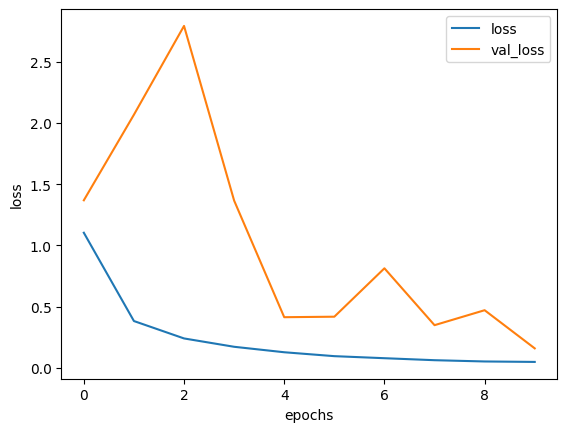

In [78]:
#plot
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()



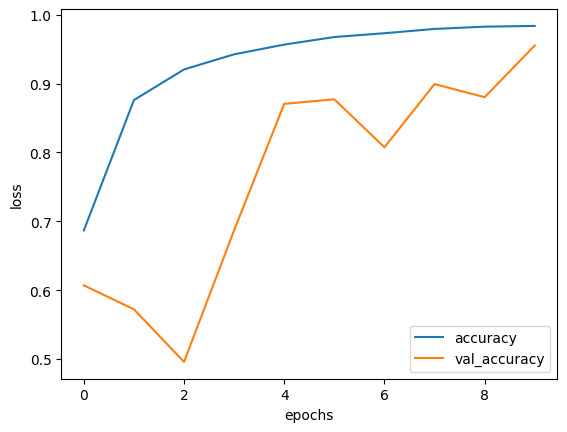

In [79]:
plt.plot(history.history['accuracy'],label = 'accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:

#preprocessiong
def preprocess_image(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path,target_size = (img_size,img_size))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img/255.0
  img = np.expand_dims(img,axis = 0)
  return img

In [99]:
#predition
class_dict = {v:k for k,v in train_data.class_indices.items()}
def predict_image(image_path):
  img = preprocess_image(image_path)
  prediction = model.predict(img,verbose = 0)
  predicted_class_index = np.argmax(prediction)
  predicted_class = class_dict[predicted_class_index]
  return predicted_class

In [102]:
predict_image('/content/plantvillage dataset/segmented/Apple___healthy/0055dd26-23a7-4415-ac61-e0b44ebfaf80___RS_HL 5672_final_masked.jpg')

'Tomato___Late_blight'

In [103]:
model.save('resnet_model.h5')

In [108]:
model.save('/content/drive/MyDrive/deeplearningmodels/Plant disease/Plant disease.h5')

In [109]:
json.dump(class_dict,open('/content/drive/MyDrive/deeplearningmodels/Plant disease/class_dict.json','w'))